In [1]:
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

sys.path.append('../')  # make sure we can import transformer_lm
torch.set_printoptions(precision=10)

%load_ext autoreload
%autoreload 2

# local imports:
from transformer_lm.test_values import SelfAttentionTestValues, MultiHeadAttentionTestValues

# Introduction to Transformer model

Till 2017-18, Recurrent neural network(RNN) were state of the art models for sequence modeling and transduction problems like language modeling and machine translation. In RNN, a sequence of hidden state $h_{t}$ are computed as a function of previous hidden state $h_{t-1}$ and input for position t. This process is sequencial and does not allow parallerlization. 

To overcome this problem, transformer based models were introduced which instead of using recurrent network employs only attention mechanism and fully connected layers.

Suggested reading - Attention Is All You Need https://arxiv.org/abs/1706.03762 

In this Homework we will implement the self attention and multi-head attention.


# Attention

There are generally two types of attention in a full Transformer model: self-attention and cross-attention. In the lecture we discussed the self-attention and this is what you will be implementing in this part of the homework.

As a warmup, you will first build a **SelfAttention** class which is an implementation of single head self attention mechanism. It will will help you better understand the idea behind attention and to jump-start the implementation of **MultiHeadAttention** class where mutliple heads are used to compute attention rather than single head.

**Note**: The purpose of SelfAttention class is not to be used in MultiAttention class but to provides a hands-on with a simple implementation of single head attention mechanism before moving onto multiple heads based attention. 

**This homework consists of two coding sections (6 tasks) and 4 inline questions**

1.  Complete **SelfAttention** class - An implementation of dot-product self-attention  
2.  Complete **MultiHeadAttention** class - An implementation of multi-head-attention  

# Coding Task 1. SelfAttention

Self attention is computed as follows

$$
Attention(Q,K,V) = softmax(\frac{QK^{T}}{\sqrt{d_{k}}})V
$$

where K, Q, and V are all projections of your input

Q = Query matrix
K = Key matrix  
V = Value matrix  
$d_{k}$ = Square root of the dimension of the key or query vector.

![image.png](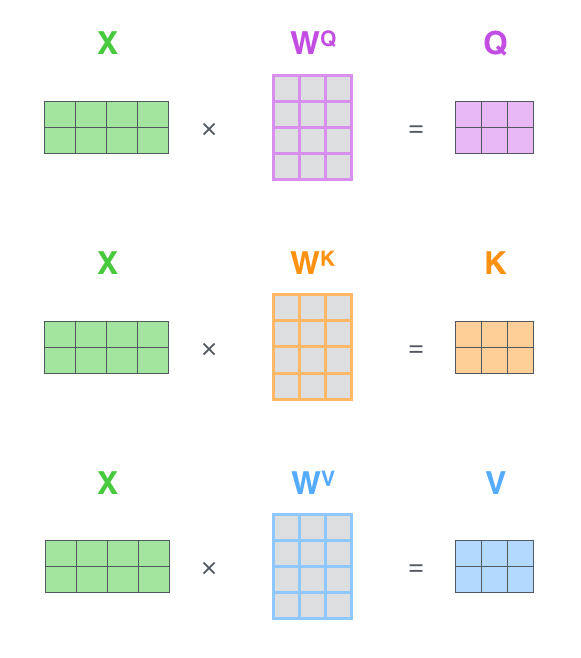
)
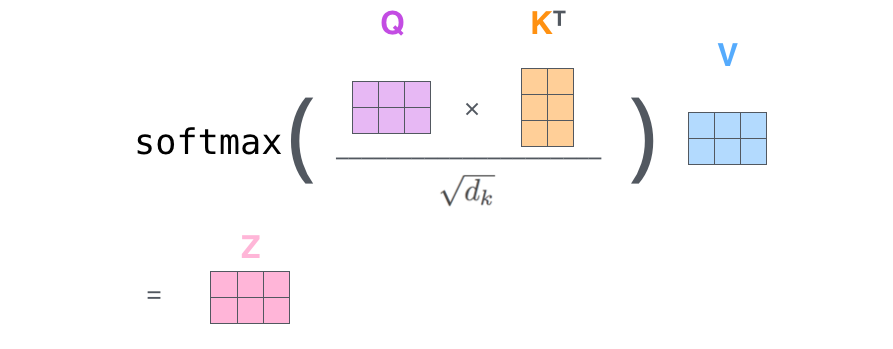

Image credit: Jay Alammar https://jalammar.github.io/illustrated-transformer

Z = Self Attention

Please read [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer) blogpost for more details.

Complete the code for the class `SelfAttention`. Read the docstring for every method you need to implement. It provides you with the information about the inputs of the function and the expected outputs. `bs` stands for batch size and `seq_len` is input sequence length.

You also need to write tensors shapes for every operation in a comment. For example, 

```python
x = x.transpose(0, 1)  # [batch, seq, h] -> [seq, batch, h]
```

## Grading Coding Task 1
**(4 points)**

* 1 point for init
* 3 points for forward (zero points if tests don't pass)
* -1 point for not following PEP-8
* -1 point for not mentioning tensor shapes in comments or for having any mistake in shape comments
* -1 point for not scaling scores
* Extra point for implementing .forward in 3 lines of pytorch code

If you are having trouble with the tests, ask TA for help.

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, input_size, hidden):
        """Self-attention module which computes softmax(xQ @ xK^T) @ xV

        Args:
            input_size: int, size of input vectors
            hidden: int, size of output vectors and hidden states
        """
        # Task 1.1: Create layers requires for self-attention (1 point)
        # YOUR CODE STARTS HERE (~4 lines)
        super().__init__()
        self.q = nn.Linear(input_size, hidden) # [input_size, hidden]
        self.k = nn.Linear(input_size, hidden) # [input_size, hidden]
        self.v = nn.Linear(input_size, hidden) # [input_size, hidden]
        self.scale = hidden ** 0.5
        # YOUR CODE ENDS HERE

    def forward(self, x):
        """Softmax(xQ @ xK^T) @ xV

        Args:
            x: FloatTensor[batch_size, seq_len, input_size]

        Returns:
            FloatTensor[batch_size, seq_len, hidden]
        """
        # Task 1.2: Compute Self Attention (3 points)
        # 1. Compute key, query and value matrices from your input x
        # 2. Compute the scores using query and key matrices
        # 3. Compute probabilities using softmax and scale the scores using
        # 4. Compute the output using probabilities and value matrices
        #
        # Write shape of each tensor for each line of code
        # for example:
        #       Suppose batch_size = 3 and seq_len = 5
        #       x = torch.zeros(3, 5) # shape [batch_size, seq_len]
        #       x = x.unqueeze(1)     # shape [batch_size, 1, seq_len]
        #
        # NOTE: Remmenber that we work with batches of data [batch_size, seq_len, hidden],
        # not just single examples [seq_len, hidden] as we did in the lecture. This changes your shapes a bit.
        #
        # YOUR CODE STARTS HERE (~ can be implemented in 4 lines or 3 if you combine steps 2 and 3 into one operation)
        q = self.q(x) # [batch_size, seq_len, hidden]
        scores = torch.bmm(q, self.k(x).transpose(1, 2)) / self.scale # [batch_size, seq_len, hidden] -> [batch_size, seq_len, seq_len] 
        probs = F.softmax(scores, dim=-1) # [batch_size, seq_len, seq_len]
        return torch.bmm(probs, self.v(x)) # [batch_size, seq_len, seq_len] @ [batch_size, seq_len, hidden] -> [batch_size, seq_len, hidden] 
        # YOUR CODE ENDS HERE


## Test SelfAttention

After implementing the SelfAttention class run the following commands to call the class and run the tests.

In [3]:
model = SelfAttention(input_size=7, hidden=9)

model.k.weight.data = SelfAttentionTestValues.k_weight
model.q.weight.data = SelfAttentionTestValues.q_weight
model.v.weight.data = SelfAttentionTestValues.v_weight

model.k.bias.data = SelfAttentionTestValues.k_bias
model.q.bias.data = SelfAttentionTestValues.q_bias
model.v.bias.data = SelfAttentionTestValues.v_bias

output = model(SelfAttentionTestValues.x)

assert output.shape == (3, 5, 9), f"shape is incorrect, expected (3, 5, 9), got {output.shape}. Check your implementation."
if not torch.allclose(output, SelfAttentionTestValues.output, atol=1e-6):
    print("Output shape is alright, but tensor values are incorrect.")
    print("Expected:")
    print(SelfAttentionTestValues.output)
    print("Got:")
    print(output)
    print("Please check your implementation.")
    assert False, "Output shape is alright, but tensor values are incorrect."

print("Tests passed!")

Tests passed!


### Inline questions:

Imagine you have two random matricies $K, Q \sim N(0, 1)$ of shape `[s, h]` and you compute $\operatorname{Softmax}(Q K^T)$.

**Q1:** How would softmax probabilities if we to increase $h$ to $2h$? Would they become more or less focused? Is is good for gradient flow?

> If you cannot show this mathematically, you can use pytorch and demonstrate it.

**Q2:** What happens if we divide attention scores by $\sqrt{h}$ before softmax?


### Type your answers here:

**A1:** If we assume that the activation values have similar distributions regardless of the number of hidden units $h$, doubling $h$ will cause the expected values of scores to double as well. This will make a few keys to have very high attention scores. It will be more focused, and it can be bad for gradient flow since gradients may vanish in part of the netwrok where the softmax function becomes very steep or flat.


**A2:** Dividing the attention scores by $\sqrt{h}$ before applying softmax can stabilize the gradients. It prevents $(Q K^T)$ from growing too large with increasing h, which can lead to extremely small or large gradients.




## Move SelfAttention to a separate file

It is a good idea to keep your neural network modules in a separate file.
By 🤗 convension we usually call them `modeling_<name_of_the_model>.py`.

Copy your SelfAttention class to `transformer_lm/modeling_attenton.py`.
You will need it in the next part of the homework.

# Coding task 2: Multi-head self-attention

Complete the **MultiheadSelfAttention** class. This layer accepts FloatTensor **[bs, seq_len, input_size]** and returns **FloatTensor[bs, seq_len, hidden_size]**. 'bs' stands for batch size and 'seq_len' is input sequence length. MultiHead attention is computed as below. 

**NOTE: Grades will be deducted if shapes of the tensors are not mentioned in your code**

Please read [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer) for more details.

$$MultiHeadAttention(Q,K,V) = Concat(head_{1}, head_{2}, ..., head_{h}) \cdot W^{O} $$ 

where$$ head_{i} = Attention(QW_{i}^{Q}, KW_{i}^{K}, VW_{i}^{V})$$

$W_{i}^{Q}$ = Weight matrix for $i^{th}$ head which will be multiplied to $i^{th}$ Query matrix  
$W_{i}^{K}$ = Weight matrix for $i^{th}$ head which will be multiplied to $i^{th}$ Key matrix  
$W_{i}^{V}$ = Weight matrix for $i^{th}$ head which will be multiplied to $i^{th}$ Value matrix  
$W^{O}$ = Weight  matrix which projects concatination of individual head attention into the final attention.


Notes:

- Your implementation should include the option to enable **casual masking**. Casual masking is applied to the scores (query -key product) to ensure that model does not pay attention to the future or current input tokens and is used for language models.
- First implement multi head attention without casual masking. By default, the arguments for casual masking is set to False (`casual=False`). 
- Remember to mix the heads before the output.

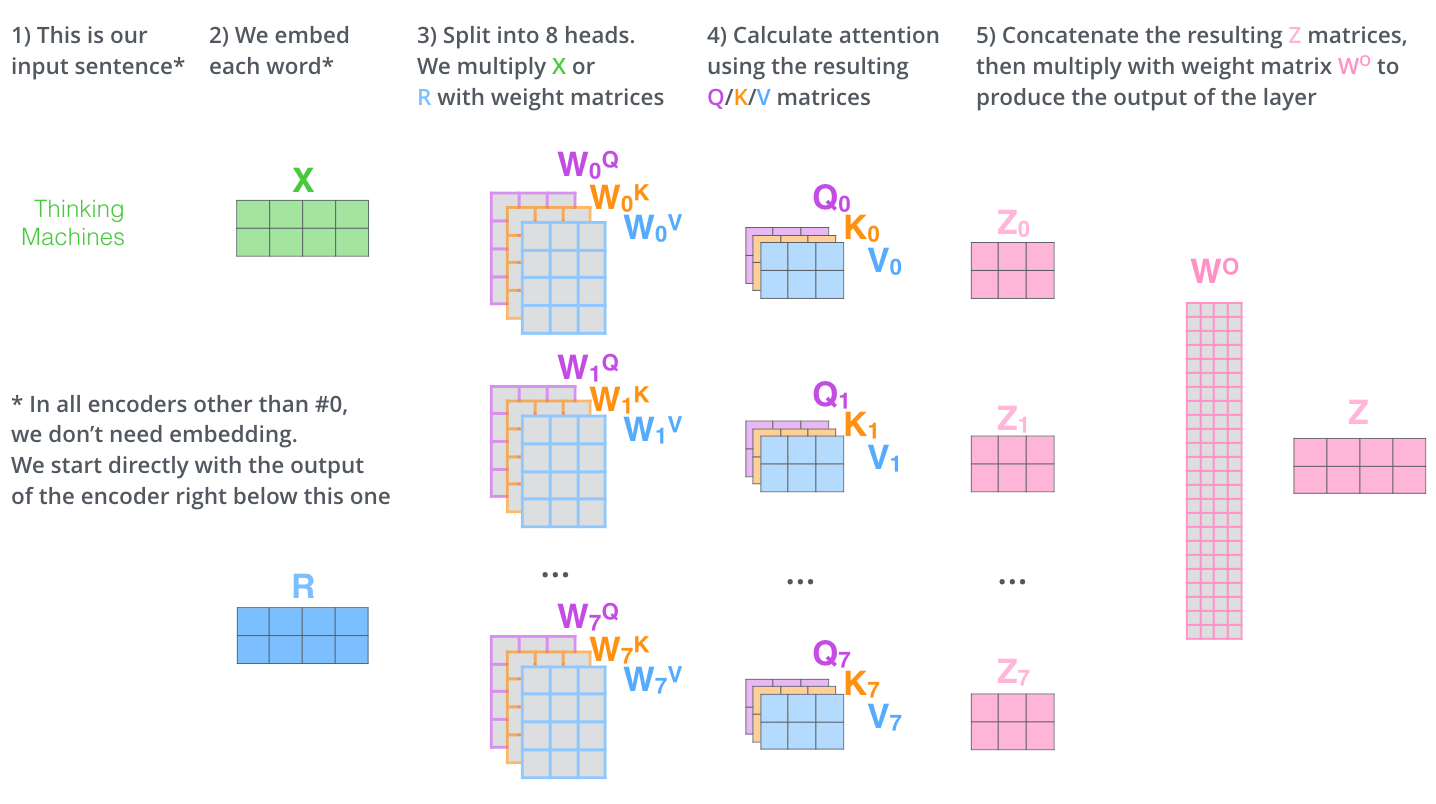

Image credit: Jay Alammar https://jalammar.github.io/illustrated-transformer

### Detailed description of Task 2.1

Compute multi-head attention scores for a given input x.

1. Compute key, query and value matrices from your input x using self.k, self.q and self.v
2. Split them into multiple heads for multihead attention. This can be efficiently achieved as a sequence of transpose and reshape operations.
3. Compute attention scores (query key product) and **scale them**

**Hint:** Your target shape is [batch * num_heads, seq, hidden / num_heads]


Notice that reshape and transpose operations are different,
for example, given a tensor of shape [M, N] .reshape (N, M) and .transpose (1, 0)
will return you **different** tensors even thought their shapes are the same.
https://jdhao.github.io/2019/07/10/pytorch_view_reshape_transpose_permute/

Write how the shape of the tensors are changing after each operation
for example, suppose 'a' is a tensor of shape [batch_size, input_size] and we apply following operation on it

```python
     a = a.unsqueeze(1).transpose() # shape [batch_size, input_size, 1] 
     # 'a' [batch_size, input_size] -> unsqueeze [batch_size, 1, input_size] -> transpose [batch_size, input_size, 1]
```

This comment explains how each operation is changing the shape of the tensor 'a' before it finally gets assigned to 'a' again.
This is just an example and does not suggest if these operations are used for this task.

### Detailed description of Task 2.2

Apply casual mask to the scores computed in Task 2.1

1. Create a casual_mask that does not allow queries to look to the future keys
Specify the device of the causal_mask tensor to be the same as the scores.device
2. Apply this casual mask on scores, fill with '-inf' where the mask is present.

You will find the following functions useful:
 - `torch.triu`
 - `.masked_fill_`

NOTE: Please write shape of the tensor for each line of code

### Detailed description of Task 2.3

Compute attention probabilities and attention vectors

1. Compute probabilities using scores, name them `probs`
   - **IMPORTANT:** make sure that your probs have the shape `[batch_size * num_heads, seq_len, seq_len]` and not `[batch_size, num_heads, seq_len, seq_len]`, because visualization code expects this shape.
2. Apply dropout to the computed probabilities (a common place to put dropout in)
3. Compute attention using probabilities
4. Apply a number of matrix transformation on attention to change its dimenion to [batch, seq, hidden] (Our implmentation has four operations)
5. Mix the attentions using self.mix, name the output `att`
Please write shape of the tensor for each line of code

**NOTE:** correct shapes do not guarantee correctness of the code. Remember the example of transposing a matrix vs reshaping it. They have the same shape but different elements.
You should understand how the reshapes and transposes are changing the elements of the tensor to correctly compute attention.

### Inline questions

**Q3:** Do we scale the scores the same way for multi-head and single-head attention?

**A3:** Yes, we still scale the scores by $\frac{1}{\sqrt{d_k}}$, where $d_k$ is the size of the key.

    
**Q4:** How many nonlinear operations do we have in self-attention? What about multi-head attention? Try to prove it.


**A4:** In self-attention, the only non-linear operation is the softmax function. So, for multi-head attention, the number of non-linear operations is the number of heads.




## Grading Coding Task 2

**(6 points)**

* 3 points for attention scores computation
* 1 point for causal masking
* 1 point for attention probabilities and attention vectors computation
* -1 point for not folling PEP8 style guide
* -1 point 

In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, input_size, hidden, num_heads, causal=False, dropout=0):
        """
        Args:
            input_size: int, size of input vectors
            hidden: int, size of output vectors and hidden states
            num_heads: int, number of attention heads, should be a divisor of hidden
            causal: use causal masking (do not allow queires to look to the keys that correspond to the future tokens)
        """
        if hidden % num_heads:
            raise ValueError(f"hidden should be divisible by num_heads, "
                             f"but got hidden={hidden} and num_heads={num_heads}")
        super().__init__()

        self.k = nn.Linear(input_size, hidden)
        self.q = nn.Linear(input_size, hidden)
        self.v = nn.Linear(input_size, hidden)
        self.mix = nn.Linear(hidden, hidden)
        self.dropout = nn.Dropout(dropout)

        self.num_heads = num_heads
        self.head_size = hidden // num_heads
        self.scale = self.head_size ** 0.5
        self.causal = causal  # causal masking

    def forward(self, x, return_attention=False):
        """Computes [Softmax(x Q_1 @ x K_1^T) @ x V_1 : ... : Softmax(x Q_heads @ x K_heads^T) @ x V_heads] @ U
        Args:
            x: FloatTensor[batch_size, seq_len, input_size]

        Returns:
            FloatTensor[batch_size, seq_len, hidden]
            if return_attention is True, returns also FloatTensor[batch_size * num_heads, seq_len, seq_len]
        """
        bs, seq, _ = x.shape

        # Task 2.1 (3 points)
        # YOUR CODE STARTS HERE (Our implementation is in 3 lines, one for each for k, q and v)
        k = self.k(x).view(bs, seq, self.num_heads, self.head_size).transpose(1, 2)
        # shape [batch_size, num_heads, seq_len, head_size]
        # 'k' [batch_size, seq_len, input_size]
        # -> view [batch_size, seq_len, num_heads, head_size]
        # -> transpose [batch_size, num_heads, seq_len, head_size]
        q = self.q(x).view(bs, seq, self.num_heads, self.head_size).transpose(1, 2)
        # shape [batch_size, num_heads, seq_len, head_size]
        # 'q' [batch_size, seq_len, input_size]
        # -> view [batch_size, seq_len, num_heads, head_size]
        # -> transpose [batch_size, num_heads, seq_len, head_size]
        v = self.v(x).view(bs, seq, self.num_heads, self.head_size).transpose(1, 2)
        # shape [batch_size, num_heads, seq_len, head_size]
        # 'v' [batch_size, seq_len, input_size]
        # -> view [batch_size, seq_len, num_heads, head_size]
        # -> transpose [batch_size, num_heads, seq_len, head_size]
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        # shape [batch_size, num_heads, seq_len, seq_len]
        # 'q' [batch_size, num_heads, seq_len, head_size]
        # @ 'k.T' [batch_size, num_heads, head_size, seq_len]
        # -> [batch_size, num_heads, seq_len, seq_len]
        # YOUR CODE ENDS HERE

        if self.causal:
            # Task 2.2 (1 point)
            # Apply casual mask to the scores
            # YOUR CODE STARTS HERE (Our implementation is in 2 lines)
            mask = torch.triu(torch.ones(seq, seq, device=x.device), diagonal=1).bool() # [seq_len, seq_len]
            scores = scores.masked_fill(mask[None, None, :, :], float('-inf'))  # [bs, num_heads, seq_len, seq_len]
            # YOUR CODE ENDS HERE

        # Task 2.3 (2 points)
        # Compute probability (probs) and attention (att), remember to apply mixing matrix
        # YOUR CODE STARTS HERE (can be implemented in 4 lines)
        probs = F.softmax(scores, dim=-1) # [bs, num_heads, seq_len, seq_len]
        probs = self.dropout(probs) # [bs, num_heads, seq_len, seq_len]

        att = torch.matmul(probs, v)
        # [bs, num_heads, seq_len, seq_len]
        # @ [bs, num_heads, seq_len, head_size] -> [bs, num_heads, seq_len, head_size]

        probs = probs.reshape(bs * self.num_heads, seq, seq)
        # 'probs' [bs, num_heads, seq_len, seq_len]
        # -> reshape [bs * num_heads, seq_len, seq_len]
        
        att = att.transpose(1, 2).contiguous().view(bs, seq, -1) # [bs, seq_len, hidden]

        att = self.mix(att)
        # [bs, seq_len, hidden] @ [hidden, hidden] -> [bs, seq_len, hidden]
        # YOUR CODE ENDS HERE

        if return_attention:
            return att, probs

        return att

## Copy implemented model to modeling_attention.py file

Copy your MultiHeadSelfAttention class to `transformer_lm/modeling_attenton.py`.
You will need it in the next part of the homework.

## Test MultiHeadSelfAttention

After implementing the MultiHeadSelfAttention class run the following commands to call the class and run some tests.

In [5]:
model = MultiHeadSelfAttention(input_size=7, hidden=9, num_heads=3)

model.k.weight.data = MultiHeadAttentionTestValues.k_weight
model.q.weight.data = MultiHeadAttentionTestValues.q_weight
model.v.weight.data = MultiHeadAttentionTestValues.v_weight
model.mix.weight.data = MultiHeadAttentionTestValues.mix_weight

model.k.bias.data = MultiHeadAttentionTestValues.k_bias
model.q.bias.data = MultiHeadAttentionTestValues.q_bias
model.v.bias.data = MultiHeadAttentionTestValues.v_bias
model.mix.bias.data = MultiHeadAttentionTestValues.mix_bias

output = model(MultiHeadAttentionTestValues.x)

assert output.shape == (3, 5, 9), f"shape is incorrect, expected (3, 5, 9), got {output.shape}. Check your implementation."
if not torch.allclose(output, MultiHeadAttentionTestValues.output):
    print("Output shape is alright, but tensor values are incorrect.")
    print("Expected:")
    print(MultiHeadAttentionTestValues.output)
    print("Got:")
    print(output)
    print("Please check your implementation.")
    assert False, "Output shape is alright, but tensor values are incorrect. Look at the output above."


## Test MultiHeadSelfAttention with causal masking

After implementing the MultiHeadSelfAttention class run the following commands to call the class and run some tests.

In [6]:
model = MultiHeadSelfAttention(input_size=7, hidden=9, num_heads=3, causal=True)

model.k.weight.data = MultiHeadAttentionTestValues.k_weight
model.q.weight.data = MultiHeadAttentionTestValues.q_weight
model.v.weight.data = MultiHeadAttentionTestValues.v_weight
model.mix.weight.data = MultiHeadAttentionTestValues.mix_weight

model.k.bias.data = MultiHeadAttentionTestValues.k_bias
model.q.bias.data = MultiHeadAttentionTestValues.q_bias
model.v.bias.data = MultiHeadAttentionTestValues.v_bias
model.mix.bias.data = MultiHeadAttentionTestValues.mix_bias

output = model(MultiHeadAttentionTestValues.x)

assert output.shape == (3, 5, 9), f"shape is incorrect, expected (3, 5, 9), got {output.shape}. Check your implementation."
if not torch.allclose(output, MultiHeadAttentionTestValues.output_causal, atol=1e-6):
    print("Output shape is alright, but tensor values are incorrect.")
    print("Expected:")
    print(MultiHeadAttentionTestValues.output_causal)
    print("Got:")
    print(output)
    print("Please check your implementation.")
    assert False, "Output shape is alright, but tensor values are incorrect. Look at the output above."

print("Tests passed!")


Tests passed!


## Demostration to understand casual masking
### 1. No casual masking

In [7]:
model = MultiHeadSelfAttention(input_size=11, hidden=15, num_heads=3, causal=False)
x = torch.randn(3, 7, 11)
att, probs = model(x, return_attention=True)

There are 3 input sequences. With first sequence of length 3, second of lenght 4 and third of length 7. Below three plots for probabilities for sequence 1, 2 and 3 no casual masking. Also note that the number of heads is 3.

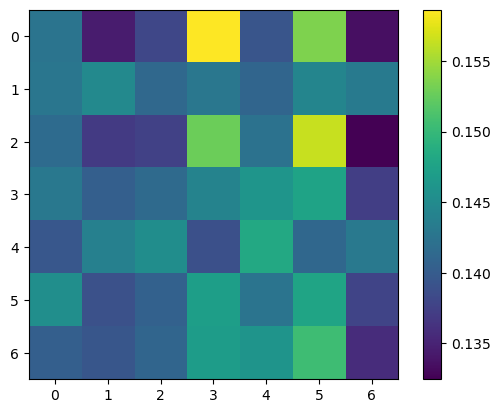

In [8]:
# sequence 1 with length 3
plt.imshow(torch.softmax(probs[0], dim=-1).detach().numpy())
plt.colorbar()

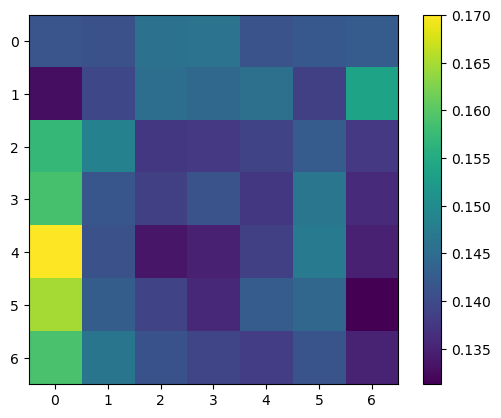

In [9]:
# sequence 2 with length 4
plt.imshow(torch.softmax(probs[3], dim=-1).detach().numpy())
plt.colorbar()

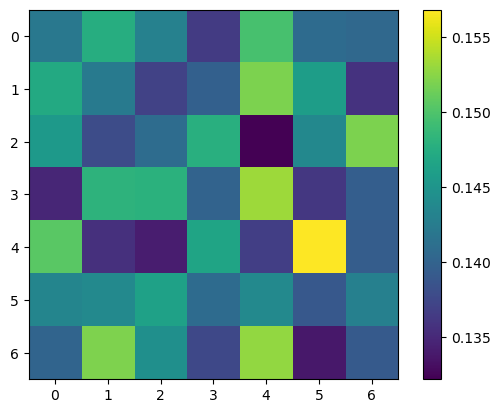

In [10]:
# sequence 3 with length 7
plt.imshow(torch.softmax(probs[6], dim=-1).detach().numpy())
plt.colorbar()

### 2. Causal masking

In [11]:
model = MultiHeadSelfAttention(input_size=11, hidden=15, num_heads=3, causal=True) # note the casual is set to True
x = torch.randn(3, 7, 11)

att, probs = model(x, return_attention=True)

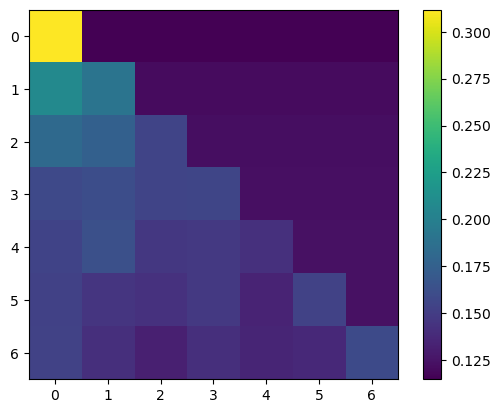

In [12]:
# check for first input sequence
# 0 + 3 heads
plt.imshow(torch.softmax(probs[0], dim=-1).detach().numpy())
plt.colorbar()

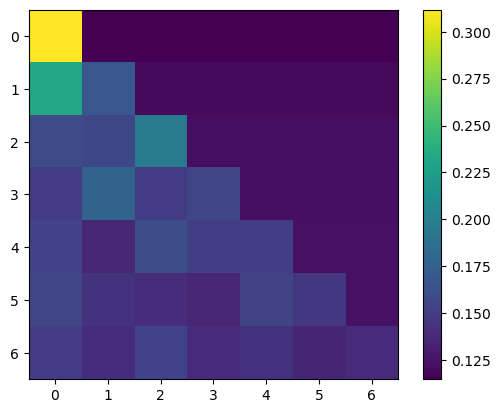

In [13]:
# check for second input sequence
# 0 + 4 heads
plt.imshow(torch.softmax(probs[3], dim=-1).detach().numpy())# check for second input sequence
plt.colorbar()

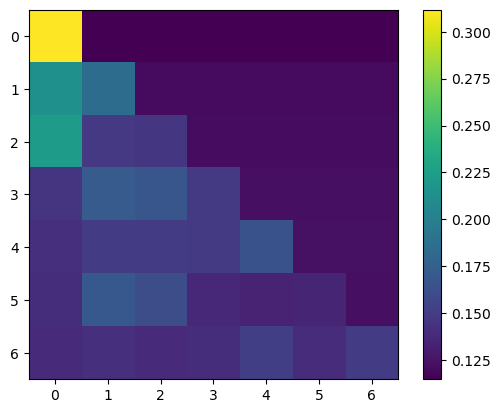

In [14]:
# check for third input sequence
# 0 + 7 heads
plt.imshow(torch.softmax(probs[6], dim=-1).detach().numpy())# check for third input sequence
plt.colorbar()

# Inline question 5:
Using above demostrations explain (with using one of the sequences as an example), what happens when 1) Causal masking is off 2) Causal masking is on

**A5:** In sequence 3, when causal masking is off, token 0 is allowed to attend to token 6 with a relatively high attention score and attend to itself with very low attention score. When causal masking is on, token 1 is only allowed to attend to itself. Using causal masking preserves the autoregressive property of the model.

